In [1]:
import pandas as pd
import io, json
import scattertext as st
from bs4 import BeautifulSoup
import numpy as np
import urllib.request
import spacy
import wordcloud
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%matplotlib inline  


/Users/kesslej/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
nlp = spacy.en.English()

In [3]:
# grap and parse the c-span trancript
url = 'https://www.c-span.org/video/?421224-1/education-secretary-nominee-betsy-devos-testifies-confirmation-hearing&live&live=&action=getTranscript&transcriptType=cc&service-url=%2Fcommon%2Fservices%2FprogramSpeakers.php&progid=465837&appearance-filter=&personSkip=0&ccSkip=0&transcriptSpeaker=&transcriptQuery=#'
with urllib.request.urlopen(url) as response:
    raw_html = response.read()
soup = BeautifulSoup(raw_html, 'html.parser')

In [4]:
transcript_df = pd.DataFrame({'speaker': [x.get_text().replace('>>','') for x in soup.find_all('strong')],
                              'speech': [x.get_text().replace('>>','') for x in soup.find_all('p')],
                             'time': [x.get_text().replace('>>','').strip() for x in soup.find_all('th')]})
# save it
transcript_df.to_csv('devos_transcript.csv')
# strip out narrator
transcript_df = transcript_df[transcript_df['speaker'] != 'Unidentified Speaker']
# strip out extraneous speaker name
transcript_df['speech'] = transcript_df['speech'].apply(lambda x: x.split(':',2)[1] if ':' in x else x)
transcript_df['surname'] = transcript_df['speaker'].apply(lambda x: 'MURKOWSKI' if x.split()[-1] == 'KRUKOWSKI' else x.split()[-1])

In [5]:
# data from govtrack.us
congress_df = pd.read_csv('https://www.govtrack.us/api/v2/role?current=true&format=csv&limit=1000')
# save it
congress_df.to_csv('congress_2017_jan.csv')

# Get the senate + Lieberman
senate_df = congress_df[congress_df['role_type'] == 'senator'].reset_index()
print(len(senate_df))
senate_df.ix[100]=pd.Series({'caucus': 'Republican', 
                  'party': 'Republican', 'person__lastname': 'Lieberman', 'person__name': 'Fmr. Sen. Joe Lieberman [I-CT]'})
print(len(senate_df))
senate_df['caucus'] = senate_df.apply(lambda x: x.party if type(x.caucus) != str else x.caucus, axis=1)
senate_df.caucus.value_counts()

100
101


Republican    53
Democrat      48
Name: caucus, dtype: int64

In [6]:

senate_df['surname'] = senate_df['person__lastname'].apply(lambda x: x.upper())

In [7]:
# get dataframe joined to
full_df = pd.merge(transcript_df, senate_df, on='surname', how='left').sort_values(by='time')

In [8]:
full_df['Caucus of Asker'] = full_df['caucus'].shift(1)
full_df['Name of Asker'] = full_df['person__name'].shift(1)
full_df['Question'] = full_df['speech'].shift(1)
full_df['Caucus of Prev. Asker'] = full_df['caucus'].shift(2)
full_df['Name of Prev. Asker'] = full_df['person__name'].shift(2)
full_df['Prev. Question'] = full_df['speech'].shift(2)
full_df['Caucus of Asker'] = full_df.apply(lambda x: x['Caucus of Asker'] if type(x['Caucus of Asker']) == str else x['Caucus of Prev. Asker'], axis=1)
full_df['Name of Asker'] = full_df.apply(lambda x: x['Name of Asker'] if type(x['Name of Asker']) == str else x['Name of Prev. Asker'], axis=1)
full_df['Question'] = full_df.apply(lambda x: x['Question'] if type(x['Question']) == str else x['Prev. Question'], axis=1)

In [9]:
# limit data frame to DeVos' answers
devos_df = full_df[full_df['speaker'] == 'MRS. DEVOS']
devos_df['metadata'] = devos_df['time'] + ': in response to ' + devos_df['Name of Asker'] + '<br>' + devos_df['Question']

In [10]:
devos_df['parsed'] = devos_df['speech'].apply(nlp)

In [11]:
corpus = (st.CorpusFromParsedDocuments(devos_df, 
                                       category_col = 'Caucus of Asker', 
                                       parsed_col = 'parsed', 
                                       feats_from_spacy_doc = st.FeatsFromSpacyDoc(strip_final_period=True))
          .build()
          .get_stoplisted_unigram_corpus())

In [12]:
html = st.produce_scattertext_explorer(corpus, 
                                       category='Democrat', 
                                       category_name='Democratic Askers', 
                                       not_category_name='Republican Askers',
                                       minimum_term_frequency=2,
                                       metadata=devos_df['metadata'],
                                       use_full_doc=True,
                                       width_in_pixels=1000)
file_name = "Devos_Answers.html"
open("Devos_Answers.html", 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=1000)

Democrat
Republican


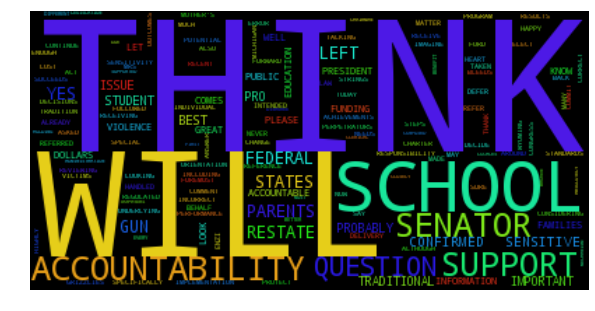

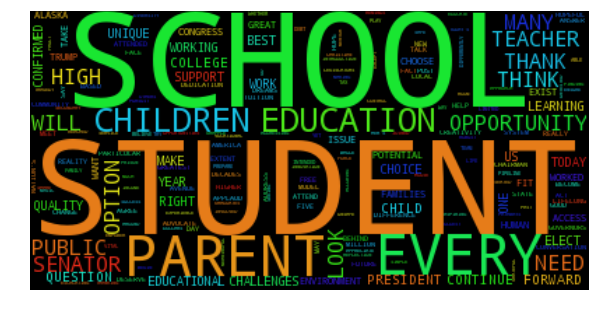

In [16]:
import matplotlib.pyplot as plt
for caucus, caucus_df in devos_df.groupby('Caucus of Asker'):
    print(caucus)
    wc = wordcloud.WordCloud().generate('\n'.join(caucus_df.speech))
    plt.figure(figsize=(10,10))
    plt.imshow(wc)
    plt.axis("off")
